## Bias Variance 1

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from IPython import display
import pandas as pd
from matplotlib import cm

In [2]:
import scipy.special

def fit_legendre_pinv(x_train, y_train, degree, x_min=-2, x_max=2):
    """Fit Legendre polynomial using pseudoinverse"""
    # Rescale x to [-1, 1]
    x_scaled = 2 * (x_train - x_min) / (x_max - x_min) - 1
    
    feature_degrees = np.arange(degree + 1)[:, None]
    X_train_poly = scipy.special.eval_legendre(feature_degrees, x_scaled).T
    beta_hat = np.linalg.pinv(X_train_poly) @ y_train
    return beta_hat

def eval_legendre_poly(beta, x, degree, x_min=-2, x_max=2):
    """Evaluate Legendre polynomial with given coefficients"""
    # Rescale x to [-1, 1]
    x_scaled = 2 * (x - x_min) / (x_max - x_min) - 1
    
    feature_degrees = np.arange(degree + 1)[:, None]
    X_poly = scipy.special.eval_legendre(feature_degrees, x_scaled).T
    return X_poly @ beta

In [3]:
random_seed=428
n_points=10
noise_level=0.2

In [4]:
def f(x): return 0.5*(x**2)

def get_noisy_data(n_points=10, noise_level=0.2, random_seed=428):
    np.random.seed(random_seed) 
    x=np.random.uniform(-2, 2, n_points)
    y=f(x)+noise_level*np.random.randn(n_points)
    return x,y

In [5]:
all_x = np.linspace(-2, 2, 128)
all_y = f(all_x)

n_train_points=int(np.floor(n_points*0.5))
n_test_points=n_points-n_train_points
x,y=get_noisy_data(n_points, noise_level, random_seed)
                   
x_train, y_train=x[:n_train_points], y[:n_train_points]
x_test, y_test=x[n_train_points:], y[n_train_points:]

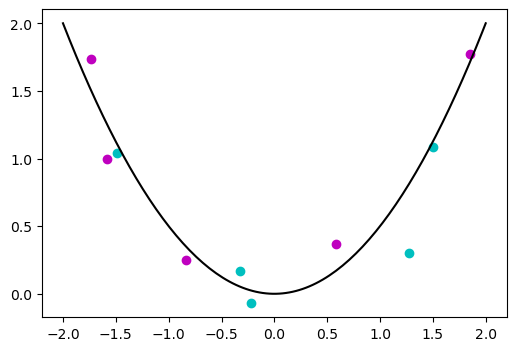

In [6]:
fig=plt.figure(0, (6, 4))
plt.plot(all_x, all_y, c='k')
plt.scatter(x_train, y_train, c='c')
plt.scatter(x_test, y_test, c='m')

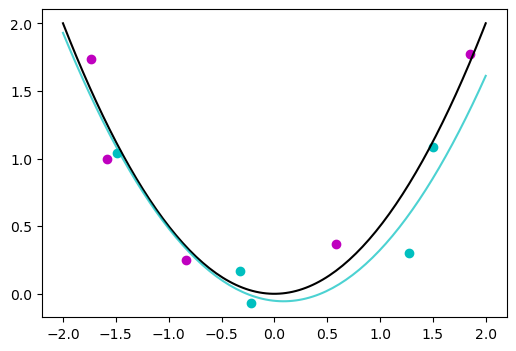

In [7]:
degree=2

beta_hat = fit_legendre_pinv(x_train, y_train, degree)
all_y_fit = eval_legendre_poly(beta_hat, all_x, degree)

y_train_pred = eval_legendre_poly(beta_hat, x_train, degree)
y_test_pred = eval_legendre_poly(beta_hat, x_test, degree)
train_error = np.mean((y_train - y_train_pred)**2)
test_error = np.mean((y_test - y_test_pred)**2)

fig=plt.figure(0, (6, 4))
plt.plot(all_x, all_y, c='k')
plt.scatter(x_train, y_train, c='c')
plt.scatter(x_test, y_test, c='m')
plt.plot(all_x, all_y_fit, color='c', label=f'Degree {degree}', alpha=0.7)

In [8]:
fits=[]
for i in range(128):
    x,y=get_noisy_data(n_points, noise_level, random_seed=i)            
    x_train, y_train=x[:n_train_points], y[:n_train_points]
    x_test, y_test=x[n_train_points:], y[n_train_points:]

    beta_hat = fit_legendre_pinv(x_train, y_train, degree)
    all_y_fit = eval_legendre_poly(beta_hat, all_x, degree)
    fits.append(all_y_fit)
fits=np.array(fits)

In [9]:
fits.shape

(128, 128)

(-1.0, 4.0)

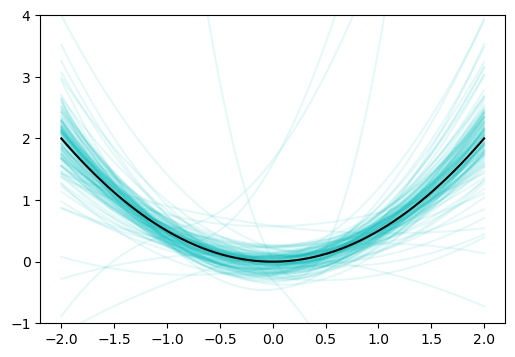

In [10]:
fig=plt.figure(0, (6, 4))
plt.plot(all_x, fits.T, color='c', label=f'Degree {degree}', alpha=0.1);
plt.plot(all_x, all_y, c='k')
# plt.scatter(x_train, y_train, c='k')
# plt.scatter(x_test, y_test, c='m')
plt.ylim([-1, 4])

Ok so I think it's just this: 

In [11]:
fits.shape

(128, 128)

In [12]:
mean_fit=np.mean(fits, 0)
bias=np.mean((all_y-mean_fit)**2) #This is actually bias squared I think
variance=np.mean((fits-mean_fit)**2) #Doing 2 reductions at once, but I feel like this is maybe correct?

In [13]:
np.mean(np.var(fits, axis=0)) #How claude does it, ok yeah it's the same - cool. 

1.3811419043823228

In [14]:
bias

0.009612643197867882

In [15]:
variance

1.3811419043823225

Checking these result with the AIs

## Claude's Approach

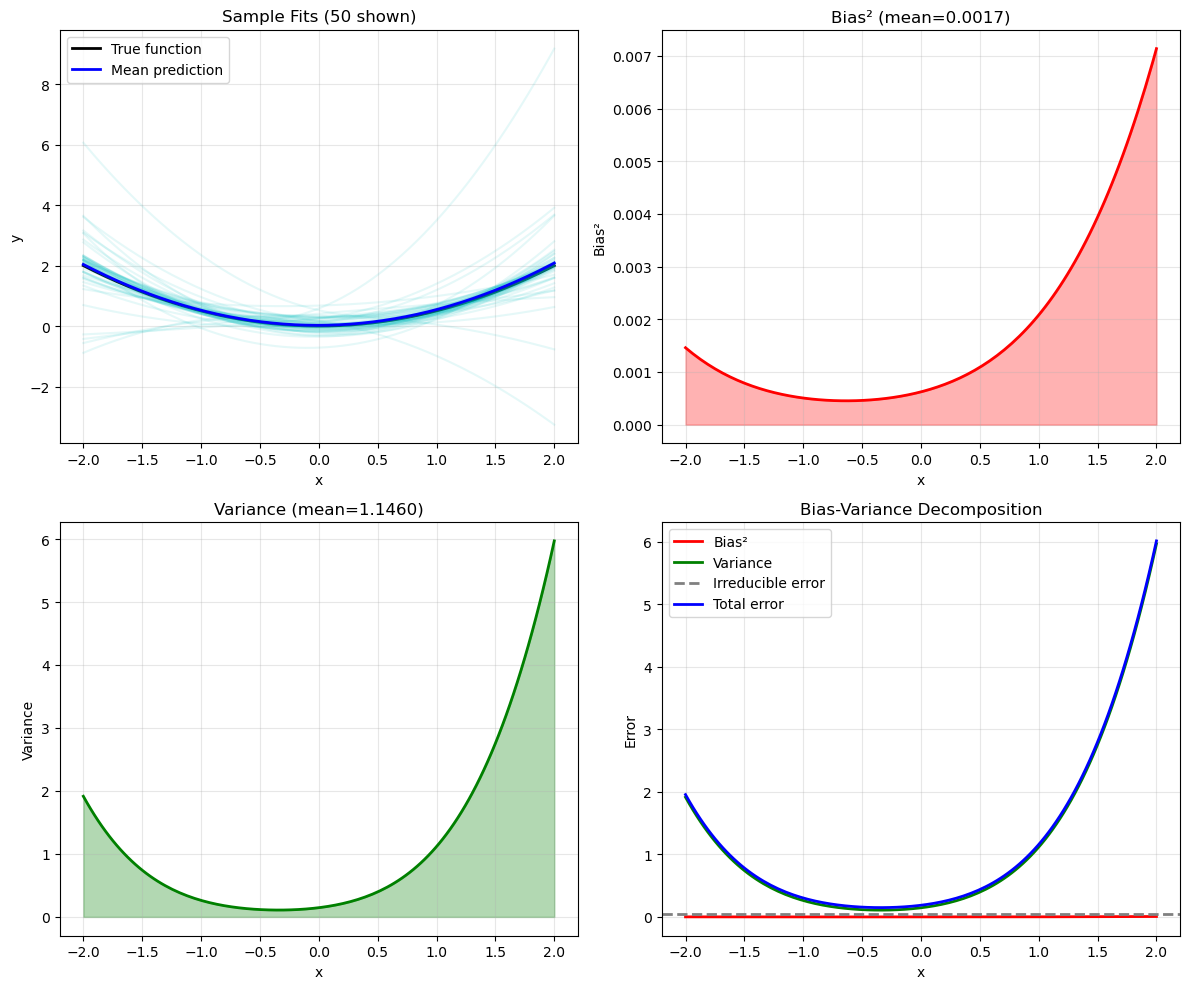


=== Bias-Variance Analysis (Degree=2) ===
Mean Bias²:            0.001692
Mean Variance:         1.146002
Irreducible Error:     0.040000
Mean Expected Error:   1.187694


In [16]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.special

# Your existing functions
def fit_legendre_pinv(x_train, y_train, degree, x_min=-2, x_max=2):
    """Fit Legendre polynomial using pseudoinverse"""
    x_scaled = 2 * (x_train - x_min) / (x_max - x_min) - 1
    feature_degrees = np.arange(degree + 1)[:, None]
    X_train_poly = scipy.special.eval_legendre(feature_degrees, x_scaled).T
    beta_hat = np.linalg.pinv(X_train_poly) @ y_train
    return beta_hat

def eval_legendre_poly(beta, x, degree, x_min=-2, x_max=2):
    """Evaluate Legendre polynomial with given coefficients"""
    x_scaled = 2 * (x - x_min) / (x_max - x_min) - 1
    feature_degrees = np.arange(degree + 1)[:, None]
    X_poly = scipy.special.eval_legendre(feature_degrees, x_scaled).T
    return X_poly @ beta

def f(x): 
    return 0.5*(x**2)

def get_noisy_data(n_points=10, noise_level=0.2, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed) 
    x = np.random.uniform(-2, 2, n_points)
    y = f(x) + noise_level * np.random.randn(n_points)
    return x, y

# Bias-Variance Decomposition
def compute_bias_variance(degree, n_simulations=1000, n_points=10, noise_level=0.2):
    """
    Compute bias and variance for a given polynomial degree
    """
    # Evaluation points
    x_eval = np.linspace(-2, 2, 128)
    y_true = f(x_eval)
    
    # Store predictions from each simulation
    predictions = np.zeros((n_simulations, len(x_eval)))
    
    n_train_points = int(np.floor(n_points * 0.5))
    
    for sim in range(n_simulations):
        # Generate new dataset
        x, y = get_noisy_data(n_points, noise_level, random_seed=None)
        x_train, y_train = x[:n_train_points], y[:n_train_points]
        
        # Fit model
        beta_hat = fit_legendre_pinv(x_train, y_train, degree)
        
        # Predict on evaluation points
        predictions[sim, :] = eval_legendre_poly(beta_hat, x_eval, degree)
    
    # Compute bias and variance
    mean_prediction = np.mean(predictions, axis=0)
    bias_squared = (mean_prediction - y_true) ** 2
    variance = np.var(predictions, axis=0)
    
    # Expected prediction error = bias^2 + variance + irreducible error
    irreducible_error = noise_level ** 2
    expected_error = bias_squared + variance + irreducible_error
    
    return {
        'x_eval': x_eval,
        'y_true': y_true,
        'mean_prediction': mean_prediction,
        'bias_squared': bias_squared,
        'variance': variance,
        'irreducible_error': irreducible_error,
        'expected_error': expected_error,
        'predictions': predictions
    }

# Compute for your degree=2 model
results = compute_bias_variance(degree=2, n_simulations=1000)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Sample fits
ax = axes[0, 0]
ax.plot(results['x_eval'], results['y_true'], 'k-', linewidth=2, label='True function')
for i in range(min(50, results['predictions'].shape[0])):
    ax.plot(results['x_eval'], results['predictions'][i], 'c-', alpha=0.1)
ax.plot(results['x_eval'], results['mean_prediction'], 'b-', linewidth=2, label='Mean prediction')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Sample Fits (50 shown)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Bias squared
ax = axes[0, 1]
ax.plot(results['x_eval'], results['bias_squared'], 'r-', linewidth=2)
ax.fill_between(results['x_eval'], 0, results['bias_squared'], alpha=0.3, color='r')
ax.set_xlabel('x')
ax.set_ylabel('Bias²')
ax.set_title(f'Bias² (mean={np.mean(results["bias_squared"]):.4f})')
ax.grid(True, alpha=0.3)

# Plot 3: Variance
ax = axes[1, 0]
ax.plot(results['x_eval'], results['variance'], 'g-', linewidth=2)
ax.fill_between(results['x_eval'], 0, results['variance'], alpha=0.3, color='g')
ax.set_xlabel('x')
ax.set_ylabel('Variance')
ax.set_title(f'Variance (mean={np.mean(results["variance"]):.4f})')
ax.grid(True, alpha=0.3)

# Plot 4: Error decomposition
ax = axes[1, 1]
ax.plot(results['x_eval'], results['bias_squared'], 'r-', linewidth=2, label='Bias²')
ax.plot(results['x_eval'], results['variance'], 'g-', linewidth=2, label='Variance')
ax.axhline(results['irreducible_error'], color='gray', linestyle='--', linewidth=2, label='Irreducible error')
ax.plot(results['x_eval'], results['expected_error'], 'b-', linewidth=2, label='Total error')
ax.set_xlabel('x')
ax.set_ylabel('Error')
ax.set_title('Bias-Variance Decomposition')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n=== Bias-Variance Analysis (Degree={2}) ===")
print(f"Mean Bias²:            {np.mean(results['bias_squared']):.6f}")
print(f"Mean Variance:         {np.mean(results['variance']):.6f}")
print(f"Irreducible Error:     {results['irreducible_error']:.6f}")
print(f"Mean Expected Error:   {np.mean(results['expected_error']):.6f}")

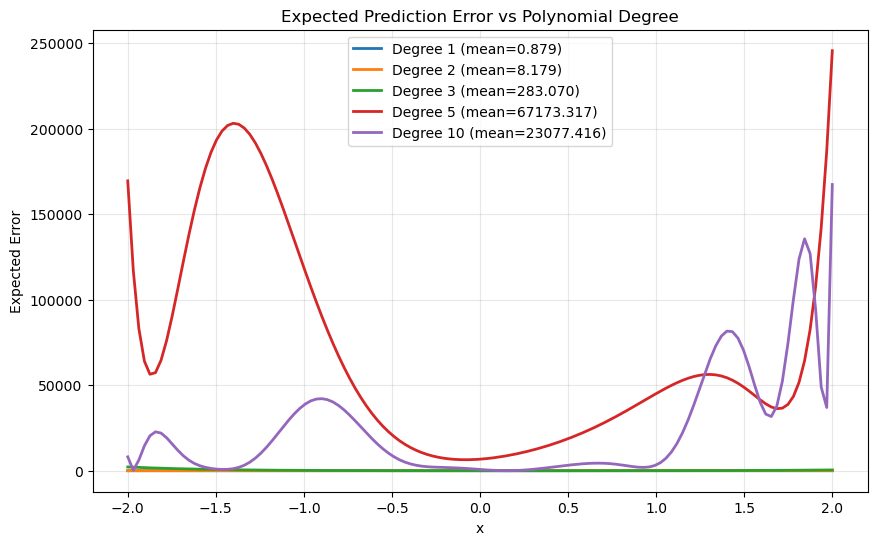


=== Summary Across Degrees ===
 Degree  Mean Bias²  Mean Variance  Mean Total Error
      1    0.403160       0.435983          0.879143
      2    0.011962       8.127282          8.179244
      3    0.468794     282.561434        283.070228
      5  172.622038   67000.655262      67173.317300
     10   33.658565   23043.717495      23077.416060


In [17]:
# Compare different degrees
degrees = [1, 2, 3, 5, 10]
comparison_results = {}

for deg in degrees:
    comparison_results[deg] = compute_bias_variance(deg, n_simulations=500)

# Plot comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for deg in degrees:
    res = comparison_results[deg]
    mean_error = np.mean(res['expected_error'])
    ax.plot(res['x_eval'], res['expected_error'], linewidth=2, label=f'Degree {deg} (mean={mean_error:.3f})')

ax.set_xlabel('x')
ax.set_ylabel('Expected Error')
ax.set_title('Expected Prediction Error vs Polynomial Degree')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# Summary table
summary = []
for deg in degrees:
    res = comparison_results[deg]
    summary.append({
        'Degree': deg,
        'Mean Bias²': np.mean(res['bias_squared']),
        'Mean Variance': np.mean(res['variance']),
        'Mean Total Error': np.mean(res['expected_error'])
    })
    
print("\n=== Summary Across Degrees ===")
print(pd.DataFrame(summary).to_string(index=False))

- Claude's bias also shoots up -> why is this? I guess the fit to the underlying function becomes poor?
- Doesn't follow theory tho....
- What if i use vandemonde basis?
- Let me check ChatGPTs answer, then come back to this. 

### ChatGPT

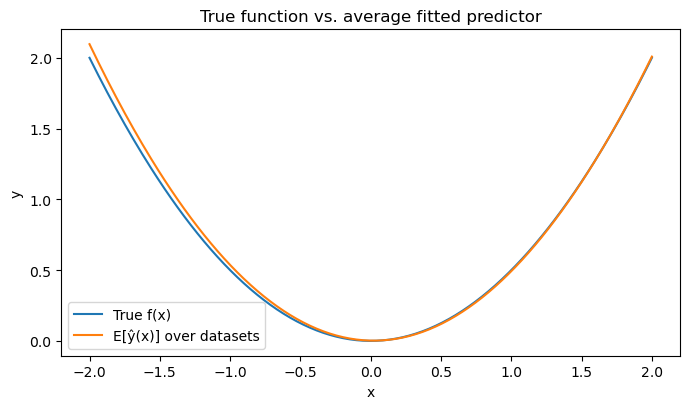

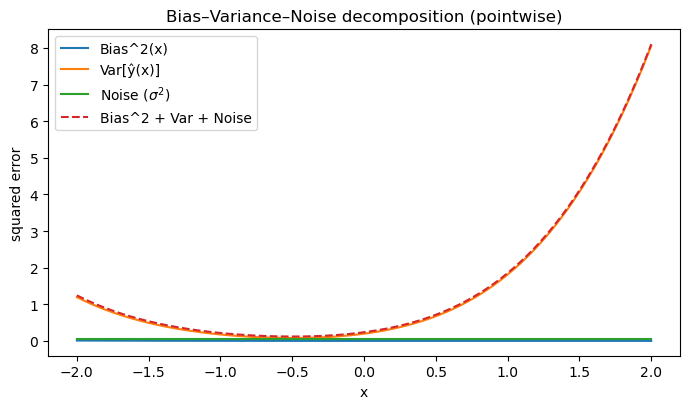

{'degree': 2,
 'n_points': 10,
 'train_frac': 0.5,
 'noise_level': 0.2,
 'trials': 400,
 'avg_bias^2': 0.0012357141505176116,
 'avg_variance': 1.465605782361879,
 'noise': 0.04000000000000001,
 'avg_pointwise_MSE': 1.5068414965123966}

In [20]:
# Bias–Variance simulation for Stephen's Legendre curvefit
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import pandas as pd
# from caas_jupyter_tools import display_dataframe_to_user

# ---- Your existing helpers (kept identical) ----
def fit_legendre_pinv(x_train, y_train, degree, x_min=-2, x_max=2):
    """Fit Legendre polynomial using pseudoinverse"""
    # Rescale x to [-1, 1]
    x_scaled = 2 * (x_train - x_min) / (x_max - x_min) - 1

    feature_degrees = np.arange(degree + 1)[:, None]
    X_train_poly = scipy.special.eval_legendre(feature_degrees, x_scaled).T
    beta_hat = np.linalg.pinv(X_train_poly) @ y_train
    return beta_hat

def eval_legendre_poly(beta, x, degree, x_min=-2, x_max=2):
    """Evaluate Legendre polynomial with given coefficients"""
    # Rescale x to [-1, 1]
    x_scaled = 2 * (x - x_min) / (x_max - x_min) - 1

    feature_degrees = np.arange(degree + 1)[:, None]
    X_poly = scipy.special.eval_legendre(feature_degrees, x_scaled).T
    return X_poly @ beta

# ---- Problem setup (feel free to tweak below) ----
def f(x): 
    return 0.5*(x**2)

x_min, x_max = -2.0, 2.0
grid = np.linspace(x_min, x_max, 256)

# Default hyperparameters (match your snippet)
n_points = 10          # total per dataset
train_frac = 0.5       # half train / half test
noise_level = 0.2
degree = 2             # polynomial degree
B = 400                # number of datasets for Monte Carlo

rng = np.random.default_rng(428)

# ---- Bias-Variance simulation ----
def simulate_bias_variance(n_points=10, train_frac=0.5, noise_level=0.2, degree=2, B=400, x_min=-2.0, x_max=2.0):
    n_train = int(np.floor(n_points*train_frac))
    n_test  = n_points - n_train
    preds = np.zeros((B, grid.size))

    for b in range(B):
        # Fresh dataset each trial
        x = rng.uniform(x_min, x_max, n_points)
        y = f(x) + noise_level*rng.standard_normal(n_points)
        # Deterministic split (first half train) to mirror your snippet;
        # since x is freshly shuffled each trial, this is effectively random.
        x_train, y_train = x[:n_train], y[:n_train]

        beta_hat = fit_legendre_pinv(x_train, y_train, degree, x_min, x_max)
        preds[b] = eval_legendre_poly(beta_hat, grid, degree, x_min, x_max)

    f_grid = f(grid)
    mean_pred = preds.mean(axis=0)
    var_pred = preds.var(axis=0, ddof=1)
    bias_sq = (mean_pred - f_grid)**2
    noise = np.full_like(grid, noise_level**2)
    mse_decomp = bias_sq + var_pred + noise

    # Averages across input space (simple uniform average over grid)
    summary = {
        "degree": degree,
        "n_points": n_points,
        "train_frac": train_frac,
        "noise_level": noise_level,
        "trials": B,
        "avg_bias^2": bias_sq.mean(),
        "avg_variance": var_pred.mean(),
        "noise": noise_level**2,
        "avg_pointwise_MSE": mse_decomp.mean()
    }
    return {
        "grid": grid,
        "f_grid": f_grid,
        "mean_pred": mean_pred,
        "bias_sq": bias_sq,
        "var_pred": var_pred,
        "noise": noise,
        "mse_decomp": mse_decomp,
        "summary": summary
    }

res = simulate_bias_variance(n_points=n_points, train_frac=train_frac, noise_level=noise_level, degree=degree, B=B, x_min=x_min, x_max=x_max)

# ---- Plots ----
# 1) Function vs average predictor
plt.figure(figsize=(7,4.2))
plt.plot(res["grid"], res["f_grid"], label="True f(x)")
plt.plot(res["grid"], res["mean_pred"], label="E[ŷ(x)] over datasets")
plt.legend()
plt.title("True function vs. average fitted predictor")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.show()

# 2) Bias–Variance–Noise decomposition (pointwise)
plt.figure(figsize=(7,4.2))
plt.plot(res["grid"], res["bias_sq"], label="Bias^2(x)")
plt.plot(res["grid"], res["var_pred"], label="Var[ŷ(x)]")
plt.plot(res["grid"], res["noise"], label="Noise ($\\sigma^2$)")
plt.plot(res["grid"], res["mse_decomp"], label="Bias^2 + Var + Noise", linestyle="--")
plt.legend()
plt.title("Bias–Variance–Noise decomposition (pointwise)")
plt.xlabel("x"); plt.ylabel("squared error")
plt.tight_layout()
plt.show()

# 3) Summary table
df = pd.DataFrame([res["summary"]])
# display_dataframe_to_user("Bias–Variance Summary", df)

res["summary"]


---

19.411837241698386 2236.0062276897265


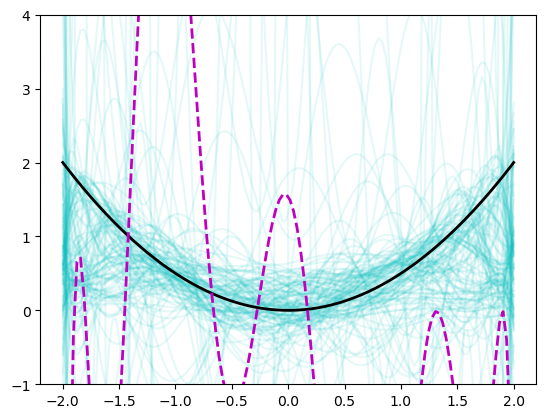

In [103]:
degree=10
n_points=10

n_train_points=int(np.floor(n_points*0.5))
n_test_points=n_points-n_train_points

fits=[]
for i in range(128):
    x,y=get_noisy_data(n_points, noise_level, random_seed=i)            
    x_train, y_train=x[:n_train_points], y[:n_train_points]
    x_test, y_test=x[n_train_points:], y[n_train_points:]

    beta_hat = fit_legendre_pinv(x_train, y_train, degree)
    all_y_fit = eval_legendre_poly(beta_hat, all_x, degree)
    fits.append(all_y_fit)
fits=np.array(fits)

mean_fit=np.mean(fits, 0)
bias=np.mean((all_y-mean_fit)**2)
variance=np.mean((fits-mean_fit)**2) 

plt.plot(all_x, fits.T, color='c', label=f'Degree {degree}', alpha=0.1);
plt.plot(all_x, all_y, c='k', linewidth=2)
plt.plot(all_x, mean_fit, 'm--', linewidth=2)
plt.ylim([-1, 4])
print(bias, variance)

In [118]:
n_points=20
biases=[]
variances=[]
for degree in range(10):
    n_train_points=int(np.floor(n_points*0.5))
    n_test_points=n_points-n_train_points
    
    fits=[]
    for i in range(128):
        x,y=get_noisy_data(n_points, noise_level, random_seed=i)            
        x_train, y_train=x[:n_train_points], y[:n_train_points]
        x_test, y_test=x[n_train_points:], y[n_train_points:]
    
        beta_hat = fit_legendre_pinv(x_train, y_train, degree)
        all_y_fit = eval_legendre_poly(beta_hat, all_x, degree)
        fits.append(all_y_fit)
    fits=np.array(fits)
    
    mean_fit=np.mean(fits, 0)
    bias=np.mean((all_y-mean_fit)**2)
    variance=np.mean((fits-mean_fit)**2) 

    biases.append(bias)
    variances.append(variance)
    
    # plt.plot(all_x, fits.T, color='c', label=f'Degree {degree}', alpha=0.1);
    # plt.plot(all_x, all_y, c='k', linewidth=2)
    # plt.plot(all_x, mean_fit, 'm--', linewidth=2)
    # plt.ylim([-1, 4])
    # print(bias, variance)

(0.0, 500.0)

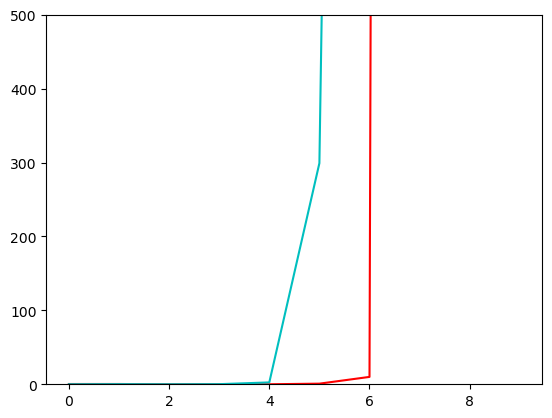

In [120]:
plt.plot(biases, 'r')
plt.plot(variances, 'c')
plt.ylim([0, 500])

- Hmm I thought my bias would just keep coming down? Is this right?
- Ah if in increase the number of points it starts to make some more sense I think?

(-1.0, 4.0)

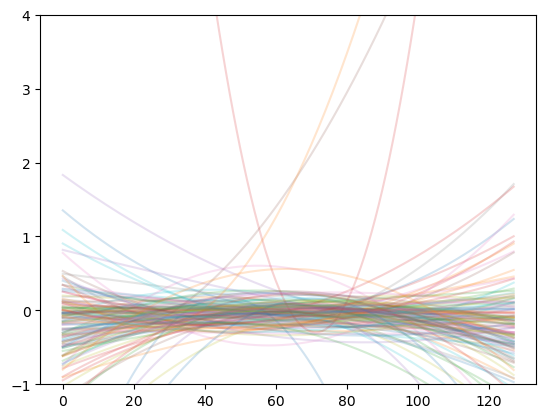

In [69]:
plt.plot((fits-mean_fit).T, alpha=0.2);
plt.ylim([-1, 4])

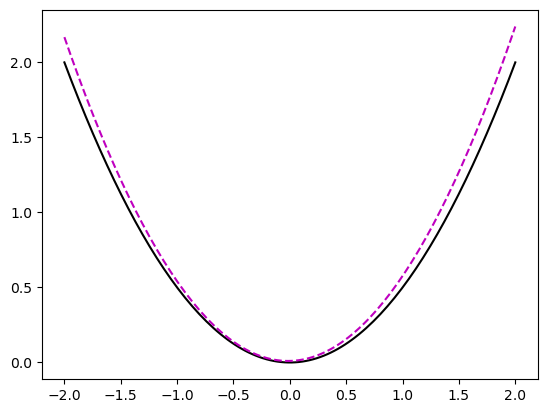

In [55]:
plt.plot(all_x, all_y, c='k')
plt.plot(all_x, mean_fit, 'm--')